#  Building a Classifier for Personal Attacks
-----
Danielle Mallare-Dani

December 9th 2021

In [59]:
import pandas as pd
import numpy as np
import urllib
import re

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict # confusion matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# import classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

## Loading Data

In [60]:
# download annotated comments and annotations

ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634' 
ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637' 

def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)

# download files only once
# download_file(ANNOTATED_COMMENTS_URL, 'attack_annotated_comments.tsv')
# download_file(ANNOTATIONS_URL, 'attack_annotations.tsv')

In [61]:
comments = pd.read_csv('attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('attack_annotations.tsv',  sep = '\t')

In [62]:
num_comments = len(annotations['rev_id'].unique())
print(f"There are {num_comments} comments in the dataset")

There are 115864 comments in the dataset


## D.) Comment Classification

To determine if a comment was an attack or not, I tried several different methods to account for different annotator opinions. I decided to experiment with averages corresponding to a majority of annotators classifying a comment as a personal attack.

Since there are 10 annotators rating each comment, more than half of the annotators classifying a comment as an attack corresponds to a comment having an average of at least 0.5. 

The following attack classification methods were experimented with:

1. Group the annotations by *rev_id*, find the mean, and classify comments with a mean greater than 0.5 as an attack

2. Group the annotations by *rev_id*, find the mean, and classify comments with a mean greater than 0.6 as an attack

3. Group the annotations by *rev_id*, find the mean, and classify comments with a mean greater than 0.7 as an attack

I also took a look at the distribution of average number of attack votes comments received (see the plot below).

It was interesting to see that the majority of comments had an average of 0 attack votes, which means that none of the 10 annotators rated the comment as an attack.

In [63]:
annotator_ratings = annotations.groupby('rev_id')['attack'].mean()

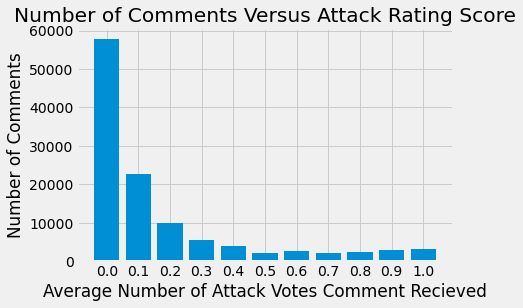

In [64]:
rating_counts = {round(0.1 * i, 1) : 0 for i in range(11)}
for rating in annotator_ratings:
    rating_counts[round(rating, 1)] += 1
    
averages = list(rating_counts.keys())
values = list(rating_counts.values())

plt.bar(range(len(rating_counts)), values, tick_label=averages)
plt.title('Number of Comments Versus Attack Rating Score')
plt.ylabel('Number of Comments')
plt.xlabel('Average Number of Attack Votes Comment Recieved')
plt.show()

Ultimately, after analyzing the distribution of average attack votes each comment received, I decided to label a comment as an attack if at least 7 out of the 10 annotators rating the comment as such. That is, if the mean is greater than 0.6.

I feel that this will account for diverse definitions and opinions of what makes a comment a personal attack. This threshold is not too high to the point that only the very vulgar and insulting comments will be classified as personal attacks, but not too low so that something that is not generally deemed offensive will not be classified as an attack.

In [65]:
# labels a comment as an attack if the majority of people did so
labels = annotations.groupby('rev_id')['attack'].mean() > 0.6

In [66]:
# join labels and comments
comments['attack'] = labels

In [67]:
comments.head()

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train,False
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train,False
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train,False
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev,False
93890,This page will need disambiguation.,2002,True,article,random,train,False


## A.) Data Exploration and Visualization

To get a feel for the data and understand how it is distributed, I inspected the dataframe as a whole and examined columns individually. I did an in depth exploration of the year, logged_in, ns, and attack columns. For each of these columns I checked for any missing or unusual data points and created several visualizations to understand the distribution of the data amongst the different categories in the column and the distribution based on how the comment was classified. This exploration also helped me to decide which features to use when training my models.

### Attack Column

When exploring the attack column, my main goal was to understand how the comment classification was distributed. I did so by creating a simple pie chart illustrating the percentage of comments classified as an attack and the percentage of comments not classified as an attack.

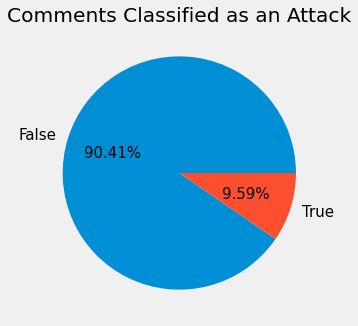

In [68]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
comments['attack'].value_counts().plot(kind='pie', autopct='%1.2f%%', 
                                          textprops={'fontsize': 15},
                                          ax=ax1)

plt.title('Comments Classified as an Attack')
plt.ylabel('')
plt.show()

#### Conclusions

As we can see in the pie chart above, an overwhelming majority of the comments in our data set are not classified as a personal attack.

### Namespace Column

When exploring the ns column of the dataset, my main question was: does namespace influence if the comment was classified as an attack? That is, is a comment more or less likely to be classified as an attack if it belongs to a certain namespace? I also did an inital look at the data using the describe() method and checking for any missing or unusual values (see below).

To determine this, I first looked at the values as a whole to check for any missing or unusual values. Then I created several types of visualizations to understand the distribution of namespace of all comments, comments classified as an attack, and comments not classified as an attack. I also created visualizations to gain an understanding of the distrubition of comment classification for each type of namespace.

In [69]:
comments.ns.describe()

count     115864
unique         2
top         user
freq       64547
Name: ns, dtype: object

In [70]:
print(f"There are {comments['ns'].isna().sum()} empty namepspace values")

There are 0 empty namepspace values


In [71]:
# Gather all attack comments
attack_comments = comments[comments['attack'] == True]

# Gather all non-attack comments
non_attack_comments = comments[comments['attack'] == False]

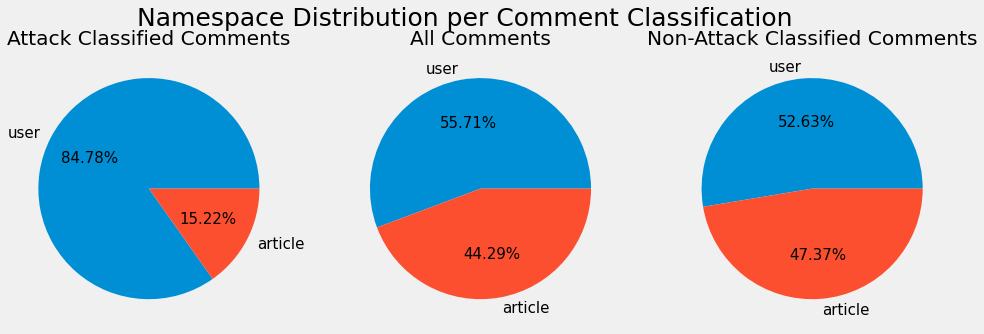

In [72]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
attack_comments['ns'].value_counts().plot(kind='pie', autopct='%1.2f%%', 
                                          textprops={'fontsize': 15},
                                          ax=ax1)
comments['ns'].value_counts().plot(kind='pie', autopct='%1.2f%%', 
                                          textprops={'fontsize': 15},
                                          ax=ax2)
non_attack_comments['ns'].value_counts().plot(kind='pie', autopct='%1.2f%%', 
                                          textprops={'fontsize': 15},
                                          ax=ax3)

ax1.title.set_text('Attack Classified Comments')
ax3.title.set_text('Non-Attack Classified Comments')
ax2.title.set_text('All Comments')
ax1.set_ylabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')

fig.suptitle('Namespace Distribution per Comment Classification', size=25)
plt.show()

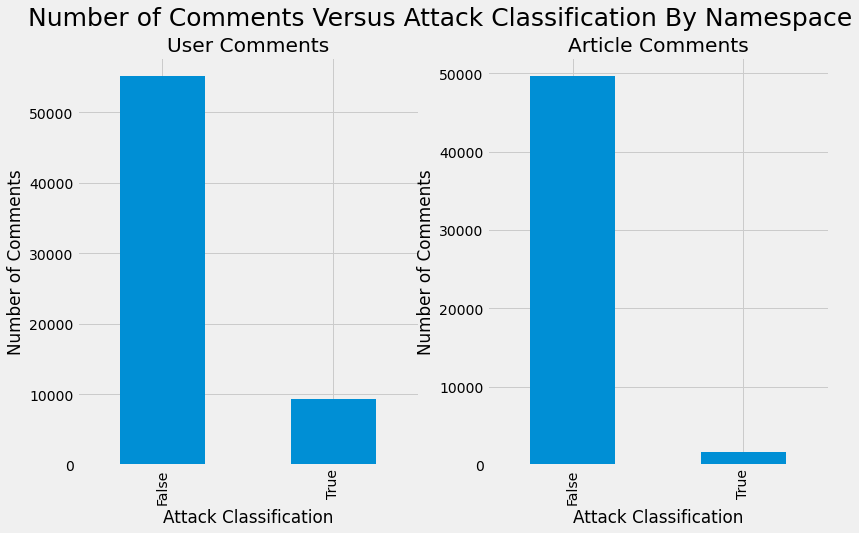

In [73]:
comments_user = comments[comments['ns'] == 'user']
comments_article = comments[comments['ns'] == 'article']

fig2, (ax4, ax5) = plt.subplots(ncols=2, figsize=(12, 7))
comments_user['attack'].value_counts().plot(kind='bar', ax=ax4)
comments_article['attack'].value_counts().plot(kind='bar', ax=ax5)

ax4.title.set_text('User Comments')
ax5.title.set_text('Article Comments')

ax4.set_xlabel('Attack Classification')
ax5.set_xlabel('Attack Classification')

ax4.set_ylabel('Number of Comments')
ax5.set_ylabel('Number of Comments')

fig2.suptitle('Number of Comments Versus Attack Classification By Namespace', size=25)
plt.show()

#### Conclusions

This anlysis convinces me that namespace does influence whether or not a comment will be classified as an attack. It seems that the majority of comments that get classified as an attack are on a user (about 85% of them). As for comments that are not classified as an attack it seems that these comments are roughly evently distributed over both namespaces and reflect the distribution that is present in all comments.

Additionally, when looking at attack classification per namespace, there are much more user comments classified as an attack than there are comments made on an article.

This analysis has led me to decide to utilize namespace within my model.

### Logged In Column

When exploring the logged_in column of the dataset, my main question was: does login status influence if the comment was classified as an attack? That is, is a comment more or less likely to be classified as an attack if the user is logged in? I also did an initial look at the data using the describe() method and checked for any missing or unusual values (see below).

I created several types of visualizations to understand the distribution of login status of all comments, comments classified as an attack, and comments not classified as an attack. I also created visualizations to gain an understanding of the distrubition of comment classification for each type of namespace.

In [74]:
comments.logged_in.describe()

count     115864
unique         2
top         True
freq       84918
Name: logged_in, dtype: object

In [75]:
print(f"There are {comments['logged_in'].isna().sum()} empty logged in values")

There are 0 empty logged in values


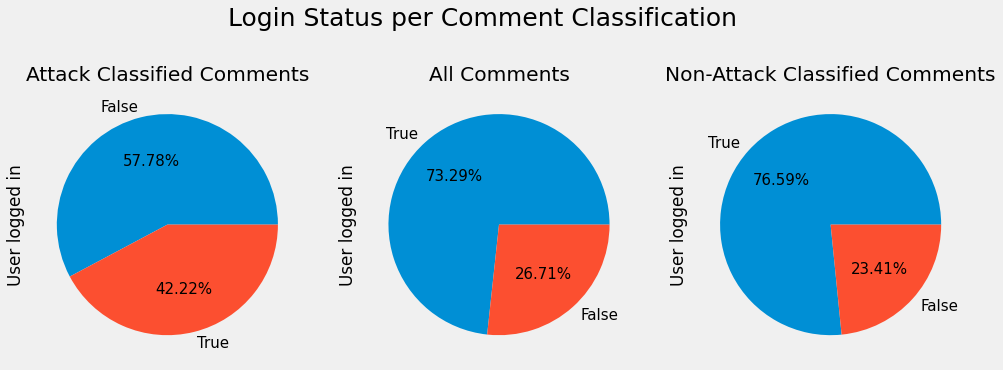

In [76]:
fig3, (ax6, ax7, ax8) = plt.subplots(ncols=3, figsize=(15, 6))
attack_comments['logged_in'].value_counts().plot(kind='pie', autopct='%1.2f%%', 
                                          textprops={'fontsize': 15},
                                          ax=ax6)
comments['logged_in'].value_counts().plot(kind='pie', autopct='%1.2f%%', 
                                          textprops={'fontsize': 15},
                                          ax=ax7)
non_attack_comments['logged_in'].value_counts().plot(kind='pie', autopct='%1.2f%%', 
                                          textprops={'fontsize': 15},
                                          ax=ax8)

ax6.title.set_text('Attack Classified Comments')
ax8.title.set_text('Non-Attack Classified Comments')
ax7.title.set_text('All Comments')
ax6.set_ylabel('User logged in')
ax7.set_ylabel('User logged in')
ax8.set_ylabel('User logged in')

fig3.suptitle('Login Status per Comment Classification', size=25)
plt.show()

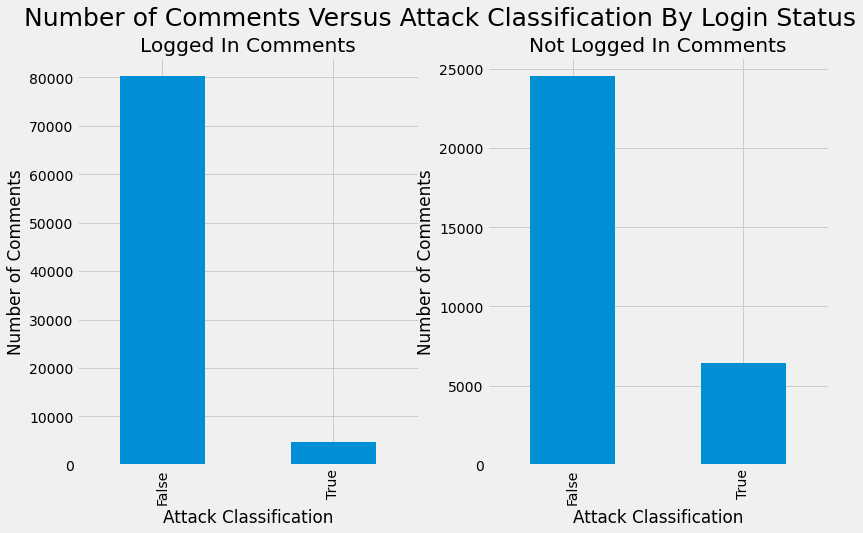

In [77]:
comments_logged_in = comments[comments['logged_in'] == True]
comments_not_logged_in = comments[comments['logged_in'] == False]

fig4, (ax9, ax10) = plt.subplots(ncols=2, figsize=(12, 7))
comments_logged_in['attack'].value_counts().plot(kind='bar', ax=ax9)
comments_not_logged_in['attack'].value_counts().plot(kind='bar', ax=ax10)

ax9.title.set_text('Logged In Comments')
ax10.title.set_text('Not Logged In Comments')

ax9.set_xlabel('Attack Classification')
ax10.set_xlabel('Attack Classification')
ax9.set_ylabel('Number of Comments')
ax10.set_ylabel('Number of Comments')

fig4.suptitle('Number of Comments Versus Attack Classification By Login Status', size=25)
plt.show()

#### Conclusions

These results suggest that login status may influence whether or not a comment will be classified as an attack. We see that the majority of comments that do not get classified as an attack are made by users who are logged in.

Additionally, we see that among comments made by users not logged in, there are many more comments classified as an attack, versus comments made among users who were logged in.

Given this analysis, I have decided to include login status when creating my model.

### Year Column

When exploring the year column, my goal was to identify if there were any years in particular where more comments than usual were classified as an attack. To explore the distribution of the data by year, I created line charts comparing the number of comments per year and the number of comments classified as an attack per year (see the charts below). 

In [78]:
# Get a feel for how the comments are distributed by year
comments['year'].describe()

count    115864.000000
mean       2009.224306
std           2.900431
min        2001.000000
25%        2007.000000
50%        2009.000000
75%        2011.000000
max        2016.000000
Name: year, dtype: float64

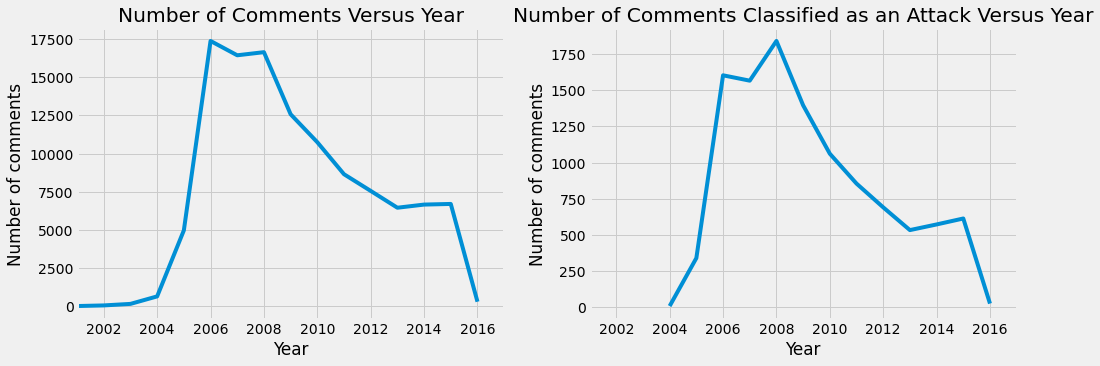

In [79]:
all_comments_by_year = comments.groupby('year')['comment'].count()

# Check how comments classified as an attack are distributed over the years
attack_comments = comments[comments['attack'] == True]
attack_comments_by_year = attack_comments.groupby('year')['attack'].sum()

fig5, (ax12, ax13) = plt.subplots(ncols=2, figsize=(15, 5))
attack_comments_by_year.plot(ax=ax13)
all_comments_by_year.plot(ax=ax12)

ax12.set_xlabel('Year')
ax12.set_ylabel('Number of comments')
ax12.set_title('Number of Comments Versus Year')
ax12.set_xlim([2001, 2017])

ax13.set_xlabel('Year')
ax13.set_ylabel('Number of comments')
ax13.set_title('Number of Comments Classified as an Attack Versus Year')
ax13.set_xlim([2001, 2017])

plt.show()

#### Conclusions

Although we do see major spikes in terms of the number of comments classified as an attack in 2008 and another one in 2006, these years are when the majority of the comments in our data set are from. We see that the line graphs for counts of overall number of comments and counts of number of comments classified as an attack are very similar in overall shape. 

Therefore, 2006 and 2008 do not seem to be particularly unique in terms of having more of a proportion of comments classified as an attack than usual. Year also does not seem to make a significant impact on whether or not a comment was classified as an attack.

This analysis led me to decide not to use the year column as a feature when training my models.

## C.) Feature Selection

I considered utilizing login status (logged_in column), year, and namespace in addition to the comment text. Ultimately, the analysis I did above and some experiments I ran led me to decide to use login status, namespace, and comment text as features in my final model.

## B.) Comment Column Exploration and Clean-Up

A brief inspection of the comments column (below) shows that comments contain various punctuation and NEWLINE_TOKEN and TAB_TOKEN. 

As a first step, I wrote a function that I could apply to the comment column that would do some text cleaning for me.
I started out by just removing the NEWLINE_TOKEN and TAB_TOKEN, removing punctuation, and converting the text to lowercase. After doing so I used the CountVectorizer with unigrams to generate a bag-of-words representation of the comment text. 

After generating the bag-of-words, I used the get_feature_names() method to inspect what was contained within the comment text. This inspection showed many numbers and other tokens including "cellpadding" and "1em"  which are associated with HTML style syntax. These observations made me decide to do some more cleaning that included removal of numbers and the HTML syntax elements that I saw.

In [80]:
comments['comment'].head(10)

rev_id
37675     `-NEWLINE_TOKENThis is not ``creative``.  Thos...
44816     `NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...
49851     NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...
89320      Next, maybe you could work on being less cond...
93890                  This page will need disambiguation. 
102817    NEWLINE_TOKEN-NEWLINE_TOKENNEWLINE_TOKENImport...
103624    I removed the following:NEWLINE_TOKENNEWLINE_T...
111032    `:If you ever claimed in a Judaic studies prog...
120283    NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENMy apol...
128532    `Someone wrote:NEWLINE_TOKENMore recognizable,...
Name: comment, dtype: object

In [81]:
# First try at cleaning the comments column
comments_copy = comments.copy()

def clean_comments1(text):
    text = text.replace("NEWLINE_TOKEN", " ")
    text = text.replace("TAB_TOKEN", " ")
    # remove punctuation
    text = re.sub(r"[=_?\-`:!,\.:;\"']", "", text)
    return text.lower()

comments_copy['comment'] = comments_copy['comment'].apply(clean_comments1)
count_vectorizer = CountVectorizer(max_features = 10000, ngram_range = (1,1))
count_vectorizer.fit_transform(comments_copy['comment'])
count_vectorizer.get_feature_names()[:25]

['00',
 '000',
 '000000',
 '01',
 '01em',
 '02',
 '03',
 '04',
 '05',
 '05em',
 '05mm',
 '06',
 '07',
 '08',
 '084080',
 '08t',
 '09',
 '10',
 '100',
 '1000',
 '10000',
 '100000',
 '101',
 '10th',
 '11']

#### Comment Text Cleanup Function Used
The following was done to clean up the comment text

1. Remove newline and tab tokens
2. Remove all numbers from comments
3. Remove punctuation
4. Remove HTML information, ex: cellpadding
5. Convert to lowercase

In [82]:
def clean_comments(text):
    text = text.replace("NEWLINE_TOKEN", " ")
    text = text.replace("TAB_TOKEN", " ")
    # remove numbers and punctuation
    text = re.sub(r"[\d=_?\-`:!,\.:;\"']", "", text)
    # replace HTML elements
    text = text.replace("cellpadding", "")
    text = re.sub(r"\sem\s", "", text)
    text = re.sub(r"\sth\s", "", text)
    text = re.sub(r"\smm\s", "", text)
    return text.lower()

comments['comment'] = comments['comment'].apply(clean_comments)
comments.head(10)

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
37675,this is not creative those are the dictionar...,2002,False,article,random,train,False
44816,the term standard model is itself less npov...,2002,False,article,random,train,False
49851,true or false the situation as of march was...,2002,False,article,random,train,False
89320,next maybe you could work on being less conde...,2002,True,article,random,dev,False
93890,this page will need disambiguation,2002,True,article,random,train,False
102817,important note for all sysops there is a bu...,2002,True,user,random,train,False
103624,i removed the following all names of early po...,2002,True,article,random,train,False
111032,if you ever claimed in a judaic studies progra...,2002,True,article,random,dev,False
120283,my apologies im english i watch cricket i ...,2002,True,article,random,dev,False


In [83]:
# inspect what words are contained in the comment text now
count_vectorizer.fit_transform(comments['comment'])
count_vectorizer.get_feature_names()[:10]

['aa',
 'aaa',
 'aaron',
 'ab',
 'abandon',
 'abandoned',
 'abbreviation',
 'abc',
 'abide',
 'abilities']

## C.) Feature Extraction

I conducted many experiments with various feature extraction techniques for each of the three machine learning models I examined. For instance, I experimented with the Tf-idf vectorizer on the (cleaned) comment text utilizing various word and character n-grams in different combinations.

The following features were utilized in the final model:

1. One hot encoding of the logged_in column (the login status of the user who authored the comment)

2. One hot encoding of the ns column (the namespace that the comment was from, 'article' or 'user')

3. Tf-idf vectorizer of the (cleaned) comment text utilizing word unigrams and bigrams
4. Tf-idf vectorizer of the (cleaned) comment text utilizing character unigrams and bigrams

## E.) Optimizations

In the following section you will observe some of the optimizations I made to my code.

- Created custom functions to allow me to systematically train, test, and conduct hyperparameter tuning for my models, and generate results in a consistent way that made it easier for me to evaluate performance.

- Used *RandomizedSearchCV* instead of exhaustive *GridSearchCV* when doing hyperparameter tuning with a lot of different parameters to try. 

- Used the *TfidfVectorizer* instead of both the *CountVectorizer* and *TfidfTransformer*.

## Modeling the Data

I experimented with three machine learning modeling methods:

1. Random Forest Classifier

2. Linear SVC

3. Logistic Regression
    


### Split data into feature and target sets

In [84]:
# Value of k for k-fold validation
K = 4

# Split data into features, X, and target, y 
y = comments['attack']
X = comments.drop(columns=['attack', 'year', 'sample', 'split'])
X.head()

,comment,logged_in,ns
rev_id,,,
37675,this is not creative those are the dictionar...,False,article
44816,the term standard model is itself less npov...,False,article
49851,true or false the situation as of march was...,False,article
89320,next maybe you could work on being less conde...,True,article
93890,this page will need disambiguation,True,article


## H.) Metric Insights

For each model I ran several trials testing different features and feature extraction methods. To evaluate these trials I looked at the macro averages of recall, precision, and f1-score. Recall, in this context, is defined as the percentage of comments correctly classified as a personal attack out of all offensive comments. That is, the percentage of offensive comments that were identified. Precision is defined as the percentage of comments that were correctly classified as a personal attack out of all comments classified as a personal attack. That is, the percentage of comments classified as an attack that were classified correctly as such.

I also considered the results obtained from generating the confusion matrix to give me an idea at how well my model did with identifying offensive comments. To do so, I converted the numerical outputs in the confusion matrix to a percentage, and paid special attention to the percentage of comments falsely classified as an attack versus the percentage of comments accurately classified as an attack. I could do this easily by comparing the bottom two rows of the confusion matrix heatmap. This analysis allowed me to gain an understanding of how frequently my model would miss classify an offensive comment as not a personal attack.

Additionally, to understand how well my model did at labeling comments that are not offensive, I compared the percentage of comments correctly classified as not an attack versus the percentage of non-offensive comments incorrectly classified as a personal attack. I could do this easily by comparing the top two rows of the confusion matrix heat map.

Ultimately, Linear SVC with the login status, namespace, and tf-idf vectorizer utilized for word unigram and bigrams and character unigrams and bigrams, performed the best in terms of the macro averages for precision, recall, and f1-score, and did the best job in terms of correctly classifying offensive comments as personal attacks and non-offensive comments as not an attack.

The function *train_test_model* defined below was utilized to systematically train and output the results of the different trials I conducted on the various machine learning models I experimented with. 

The code below shows the process that I took to determine the features to utilize with Linear SVC. I also include a run with the most performant machine learning model and feature extraction combination. These results are without hyperparameter tuning.

Note: The code to generate the confusion matrix heat map was found in this article:

https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/

## Effects of Cross-Validation
Each model was trained using k-fold cross-validation with $k = 4$. To get a first look at how the model performed, I also trained the model without utilizing k-fold cross-validation and split my data into train and test sets with 20% of the data reserved for testing.

Training with k-fold cross-validation resulted in an approximate increase of almost one percentage point of macro average recall and generally less than half a percentage increase in macro average precision. These increases are due to the fact that k-fold cross-validation allows us to utilize all of the data for training and increases the performance of the model due to the fact that we are evaluating the effectiveness of k different models generated from subsets of our data. 

When applying k-fold cross-validation, I set the scoring parameter to consider the macro averages of recall, precision, and f1-score. I feel that cross-validation led to more of an increase in average macro recall because of the fact that the data contains a majority of comments that are not offensive. By training our model with all data, we give ourselves more offensive comments to work with. This additional data helps train the model to better recognize an offensive comment when presented with one.

In [85]:
def train_test_model(pipeline, pipeline_name, K, X, y):
    """
    Trains the model with K-fold cross-validation specified by 
    the given pipeline identified as pipeline_name 
    with feature dataset X and target dataset y.
    Outputs a report of scores that include average macro recall,
    precision, and f1-score
    """
    scoring = ['precision_macro', 'recall_macro', 'f1_macro']
    
    clf = cross_validate(
        pipeline, X, y, cv=K, 
        scoring=scoring
    )
    
    # Print report of results
    precision_macro_avg = clf['test_precision_macro'].mean()
    recall_macro_avg = clf['test_recall_macro'].mean()
    f1_macro_avg = clf['test_f1_macro'].mean()

    print(f"Results for {pipeline_name}:")
    print("Precision macro average: " + "{:.4f}".format(precision_macro_avg))
    print("Recall macro average: " + "{:.4f}".format(recall_macro_avg))
    print("F1 macro average: " + "{:.4f}".format(f1_macro_avg))

In [86]:
def generate_confusion_matrix_plot(cm, method_name):
    ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

    ax.set_title(f"Confusion Matrix: {method_name}");
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values    ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

To determine which features to use for a model, I conducted several different trials using different combinations of features. The results of some of these trials are shown below.

#### Trial 1.

1. Comment column: Char ngram vectorizer with unigrams
2. Namespace column: One hot encoding
3. Logged in column: One hot encoding

##### Results for Linear SVC Trial 1:

PrePrecision macro average: 0.8545

Recall macro average: 0.6120

F1 macro average: 0.6568

The results from trial one that utilized just the tf-idf vectorizer with character unigrams showed me that incorporating the tf-idf vectorizer with words could lead me to better results. In particular, the recall results were 18 percentage points power than what was achieved with the strawman model. From the confusion matrix generated below, we see that more offensive comments are misclassified much more often than correctly classified as attacks.

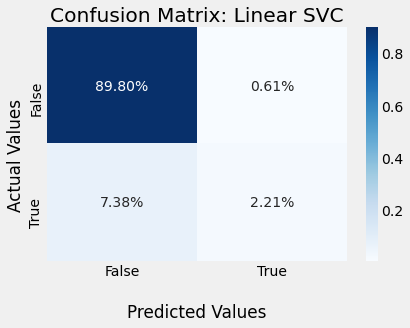

In [108]:
cm1 = np.array([[104050, 707],
                [8545, 2562]])
generate_confusion_matrix_plot(cm1, 'Linear SVC')

#### Trial 2.

1. Comment column: word vectorizer with unigrams
2. Namespace column: One hot encoding
3. Logged in column: One hot encoding

##### Results for Linear SVC Trial 2:

Precision macro average: 0.9028

Recall macro average: 0.8202

F1 macro average: 0.8553

When using word unigrams with the tf-idf vectorizer I saw results that exceeded the recall, precision, and f1-score results from the strawman model. I was also very pleased to see from glancing at the confusion matrix that this model correctly classified offensive comments as an attack the majority of the time.

Although results improved significantly across the board, I wanted to see the effect of utilizing both word and character tf-idf vectorizers.

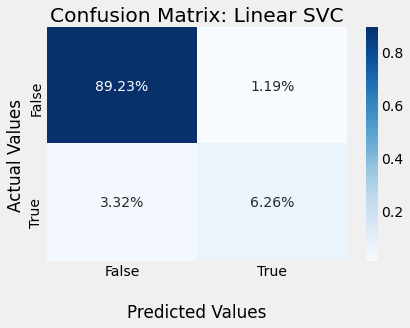

In [109]:
cm2 = np.array([[103381, 1376],
                 [3849, 7258]])
generate_confusion_matrix_plot(cm2, 'Linear SVC')

#### Trial 3.

1. Comment column: word vectorizer and character vectorizer, unigrams for both
2. Namespace column: One hot encoding
3. Logged in column: One hot encoding

The code for this trial and results obtained are shown below

Results for Linear SVC Trial 3:
Precision macro average: 0.9024
Recall macro average: 0.8236
F1 macro average: 0.8574


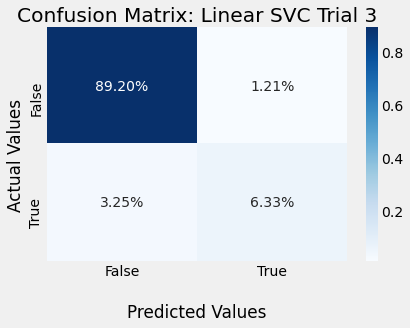

In [110]:
namespace_one_hot_encoder = OneHotEncoder()
login_status_one_hot_encoder = OneHotEncoder()
comment_word_vectorizer = TfidfVectorizer(analyzer='word')
comment_char_vectorizer = TfidfVectorizer(analyzer='char')

combined_vectorizers = FeatureUnion([
    ("word", comment_word_vectorizer),
    ("char", comment_char_vectorizer)
])

preprocessor3 = ColumnTransformer([
    ('namespace', namespace_one_hot_encoder, ['ns']),
    ('loginstatus', login_status_one_hot_encoder, ['logged_in']),
    ('comments', combined_vectorizers, 'comment')
])

linear_svc_pipeline3 = Pipeline([
    ('preprocessor', preprocessor3),
    ('model', LinearSVC())
])

train_test_model(linear_svc_pipeline3,'Linear SVC Trial 3', K, X, y)
y_pred = cross_val_predict(linear_svc_pipeline3, X, y, cv=K)
cm3 = confusion_matrix(y, y_pred)

generate_confusion_matrix_plot(cm3, 'Linear SVC Trial 3')

The results showed slight increases in precision and recall which led me to try both vectorizers with unigrams and bigrams.

#### Trial 4. 

This trial ended up being the best trial. The results are shown below. The full run of this trial will be in a subsequent section.

1. Comment column: word vectorizer and character vectorizer, unigrams and bigrams for both
2. Namespace column: One hot encoding
3. Logged in column: One hot encoding

##### Results for Linear SVC Trial 4:

Precision macro average: 0.9130

Recall macro average: 0.8293

F1 macro average: 0.8650


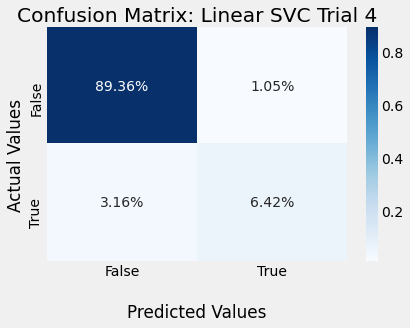

In [111]:
cm4 = np.array([[103540, 1217],
                [3663, 7444]]
)
generate_confusion_matrix_plot(cm4, 'Linear SVC Trial 4')

This experiment resulted in yet another slight increase in precision and recall, so I decided to test what would happen if I utilized unigrams, bigrams, and trigrams with both vectorizers.

#### Trial 5.

1. Comment column: word vectorizer and character vectorizer, unigram, bigrams, and trigrams for both
2. Namespace column: One hot encoding
3. Logged in column: One hot encoding

##### Results for Linear SVC Trial 5:

Precision macro average: 0.9103

Recall macro average: 0.8250

F1 macro average: 0.8612

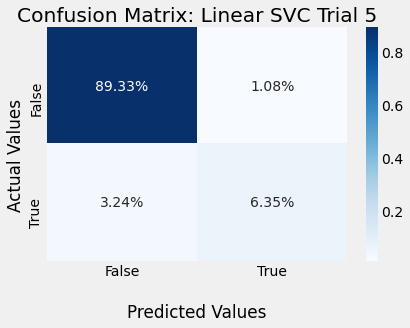

In [112]:
cm5 = np.array([[103507, 1250],
                 [3754, 7353]])
generate_confusion_matrix_plot(cm5, 'Linear SVC Trial 5')

Since this trial led to a slight decrease in overall precision and recall, and in ability to correctly classify offensive comments, I decided to stick with utilizing unigrams and bigrams for both the character and word vectorizers.

### Run of Linear SVC with the best combination of features (without hyperparameter tuning)

All of this experimentation led me to the best set of features, trained and tested in the code below.

Results for Linear SVC:
Precision macro average: 0.9130
Recall macro average: 0.8293
F1 macro average: 0.8650


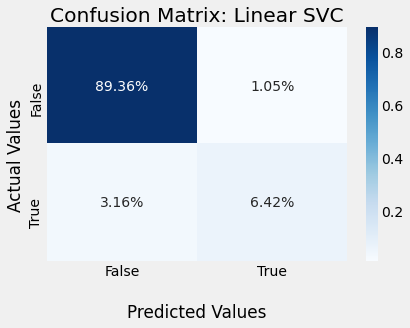

In [91]:
# Feature extraction
namespace_one_hot_encoder = OneHotEncoder()
login_status_one_hot_encoder = OneHotEncoder()
comment_word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2))
comment_char_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1,2))

# Use FeatureUnion to include both word and character unigrams and bigrams for comment text
combined_vectorizers = FeatureUnion([
    ("word", comment_word_vectorizer),
    ("char", comment_char_vectorizer)
])

# ColumnTransformer is utilized to incorporate other non-word features of the dataset,
# specifically login status and namespace
preprocessor = ColumnTransformer([
    ('namespace', namespace_one_hot_encoder, ['ns']),
    ('loginstatus', login_status_one_hot_encoder, ['logged_in']),
    ('comments', combined_vectorizers, 'comment')
])

linear_svc_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearSVC())
])

train_test_model(linear_svc_pipeline,'Linear SVC', K, X, y)
y_pred = cross_val_predict(linear_svc_pipeline, X, y, cv=K)
cm = confusion_matrix(y, y_pred)
generate_confusion_matrix_plot(cm, 'Linear SVC')

## Hyperparameter Tuning

For Linear SVC I investigated the effects of the value of the regularization parameter C and the class weight. My hope, in particular, was that using a balanced class weight would help adjust for the inbalanced dataset that we are working with.

Values of C considered: 0.1, 1, 10, 100

Class weights considered: None and balanced

I also explored various values of maximum document frequency (max_df), maximum features (max_features), and the usage of stop words with my tf-idf word vectorizer.

Values of max_df considered: 0.8, 0.9, 1.0 (default)

Values of max_features considered: 10,000 and None (default)

Stop word lists considered: None (default), 'english'

To systematically hypertune my models, I created the function (shown below).

In [100]:
def hyperparameter_tuning(pipeline, pipeline_name, param_grid, K, X, y, randomized=False, scoring='f1_macro'):    
    if randomized:
        grid_search = RandomizedSearchCV(
                          estimator=pipeline,
                          param_distributions=param_grid,
                          verbose=10,
                          scoring=scoring,
                          cv=K,
                          n_jobs=-1)
    else:
        grid_search = GridSearchCV(
                          estimator=pipeline,
                          param_grid = param_grid,
                          verbose=10,
                          scoring=scoring,
                          cv=K,
                          n_jobs=-1)

    # Fit with the best parameters
    grid_search = grid_search.fit(X, y)
    
    # Print a report of the results
    print(f"Results for {pipeline_name}:")
    print("Best F1-Score: %0.4f" % grid_search.best_score_)
    
    print("Best parameters set:")
    best_params = grid_search.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print("\t%s: %r" % (param_name, best_params[param_name]))
    
    return grid_search.best_estimator_

In [104]:
param_grid_lin_svc = dict(
                      preprocessor__comments__word__max_df=[0.8, 0.9, 1.0],
                      preprocessor__comments__word__max_features=[10000, None],
                      preprocessor__comments__word__stop_words=["english", None],
                      model__C=[0.1, 1, 10, 100],
                      model__class_weight=[None, 'balanced']
    
)


best_lin_svc_estimator = hyperparameter_tuning(
    linear_svc_pipeline, 
    'Linear SVC', 
    param_grid_lin_svc, K, X, y,
    randomized=True
)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Results for Linear SVC:
Best F1-Score: 0.8722
Best parameters set:
	model__C: 1
	model__class_weight: 'balanced'
	preprocessor__comments__word__max_df: 0.8
	preprocessor__comments__word__max_features: None
	preprocessor__comments__word__stop_words: None


In [105]:
train_test_model(best_lin_svc_estimator,'Linear SVC Best Model', K, X, y)
y_pred = cross_val_predict(best_lin_svc_estimator, X, y, cv=K)
cm = confusion_matrix(y, y_pred)

Results for Linear SVC Best Model:
Precision macro average: 0.8774
Recall macro average: 0.8677
F1 macro average: 0.8722


### Conclusion

In conclusion, hyperparameter tuning improved the macro average f1-score by 0.72% to 87.22%. It did cause a slight decrease in macro average precision, but that decrease translated to a slightly higher increase in recall, causing the overall accuracy to increase. 

Since f1-score is the harmonic mean of precision and recall, the gains in recall that outpaced the loss in precision caused the f1-score to raise slightly.

## I.) Results with Best Overall Model 

The best overall results are below. Whe compared to the strawman figure, average macro precision increased by approximately 8%, average macro recall increased by approximately 7%, and the average macro f1-score increased by approximately 7%.

Linear SVC with a regularization parameter, C, value of 1.0 and balanced class weight led to this result.

Additionally, word and character unigram and bigram vectorizers were utilized along with the login status and namespace features. The word vectorizer did not utilize stop words, had a maximum document frequency of 0.8, and had no maximum set for the number of features.


In [106]:
train_test_model(best_lin_svc_estimator,'Best Overall Model', K, X, y)
y_pred = cross_val_predict(best_lin_svc_estimator, X, y, cv=K)
cm = confusion_matrix(y, y_pred)

Results for Best Model:
Precision macro average: 0.8774
Recall macro average: 0.8677
F1 macro average: 0.8722


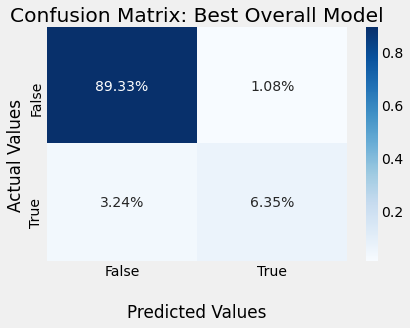

In [107]:
generate_confusion_matrix_plot(cm5, 'Best Overall Model')

## F.) Summary of Experiments

Shown below are a snapshot of results obtained before hyperparameter tuning. I have also included a section of best results per model after hyperparameter tuning. Note that Linear SVC utilizing login status, namespace, and word and character unigram and bigram vectorizers did the best before tuning hyperparameters.

For each machine learning model, various trials were run and the following data was generated:

1. Precision macro average
2. Recall macro average
3. F1 macro average
4. Confusion matrix plotted as a heat map. The confusion matrix counts were converted to percentages to be able to easily compare results and determine the accuracy of the model generated from each trial.

Some preliminary trials (described in the next subsection) were also run to determine the best cut off for labeling a comment as a personal attack based on annotator ratings and which features to use.

### Preliminary Trials

To get a feel for what features I should use, attack thresholds, etc. I did some preliminary experiments as listed below.

The results are included with the trial that performed the best out of all trials in this section.

#### Trial 1.

- Features used:
    - Comment column: word vectorizer with unigrams
- Attack Classification: Group the annotations by *rev_id*, find the mean, and classify comments with a mean greater than 0.5 as an attack
- Model: Linear SVC

#### Trial 2.

- Features used:
    - Comment column: word vectorizer with unigrams
- Attack Classification: Group the annotations by *rev_id*, find the mean, and classify comments with a mean greater than 0.6 as an attack
- Model: Linear SVC

#### Trial 3.

- Features used:
    - Comment column: word vectorizer with unigrams
- Attack Classification: Group the annotations by *rev_id*, find the mean, and classify comments with a mean greater than 0.7 as an attack
- Model: Linear SVC

#### Trial 4 .

- Features used:
    - Comment column: word vectorizer with unigrams
    - namespace column with one hot encoding
- Attack Classification: Group the annotations by *rev_id*, find the mean, and classify comments with a mean greater than 0.5 as an attack
- Model: Linear SVC

#### Trial 5.

- Features used:
    - Comment column: word vectorizer with unigrams
    - namespace column with one hot encoding
- Attack Classification: Group the annotations by *rev_id*, find the mean, and classify comments with a mean greater than 0.6 as an attack
- Model: Linear SVC

#### Trial 6.

- Features used:
    - Comment column: word vectorizer with unigrams
    - namespace column with one hot encoding
    - logged in column with one hot encoding
- Attack Classification: Group the annotations by *rev_id*, find the mean, and classify comments with a mean greater than 0.5 as an attack
- Model: Linear SVC

#### Trial 7. Best Result

- Features used:
    - Comment column: word vectorizer with unigrams
    - namespace column with one hot encoding
    - logged in column with one hot encoding
- Attack Classification: Group the annotations by *rev_id*, find the mean, and classify comments with a mean greater than 0.6 as an attack
- Model: Linear SVC and decision tree


##### Results for Preliminary Trial 7

Precision macro average: 0.9026

Recall macro average: 0.8224

F1 macro average: 0.8570

#### Trial 8.

- Features used:
    - Comment column: word vectorizer with unigrams
    - namespace column with one hot encoding
    - logged in column with one hot encoding
- Attack Classification: Group the annotations by *rev_id*, find the mean, and classify comments with a mean greater than 0.7 as an attack
- Model: Linear SVC and decision tree

#### Trial 9.

- Features used:
    - Comment column: word vectorizer with unigrams
    - namespace column with one hot encoding
    - logged in column with one hot encoding
- Attack Classification: Group the annotations by *rev_id*, find the mean, and classify comments with a mean greater than 0.6 as an attack
- Upsampling of the minority class (comments classified as an attack)
- Model: Linear SVC and decision tree


### Linear SVC Trials

The results are included with the trial that performed the best out of all trials in this section.

#### Trial 1.

1. Comment column: Char ngram vectorizer with unigrams
2. Namespace column: One hot encoding
3. Logged in column: One hot encoding

#### Trial 2.

1. Comment column: word vectorizer with unigrams
2. Namespace column: One hot encoding
3. Logged in column: One hot encoding

#### Trial 3.

1. Comment column: word vectorizer and character vectorizer, unigrams for both
2. Namespace column: One hot encoding
3. Logged in column: One hot encoding

#### Trial 4. Best Trial

1. Comment column: word vectorizer and character vectorizer, unigram and bigrams for both
2. Namespace column: One hot encoding
3. Logged in column: One hot encoding

##### Results for Linear SVC Trial 4:

Precision macro average: 0.9130

Recall macro average: 0.8293

F1 macro average: 0.8650

#### Trial 5.

1. Comment column: word vectorizer and character vectorizer, unigram, bigrams, and trigrams for both
2. Namespace column: One hot encoding
3. Logged in column: One hot encoding

#### Trial 6.

1. Comment column: char vectorizer, with unigrams and bigrams
2. Namespace column: One hot encoding
3. Logged in column: One hot encoding

### Logistic Regression Trials

The results are included with the trial that performed the best out of all trials in this section.

#### Trial 1.

1. Comment column: Char ngram vectorizer with unigrams
2. Namespace column: One hot encoding
3. Logged in column: One hot encoding

#### Trial 2.

1. Comment column: word vectorizer with unigrams
2. Namespace column: One hot encoding
3. Logged in column: One hot encoding

#### Trial 3. 

1. Comment column: word vectorizer and character vectorizer, unigrams for both
2. Namespace column: One hot encoding
3. Logged in column: One hot encoding

#### Trial 4. Best Trial

1. Comment column: word vectorizer and character vectorizer, unigram and bigrams for both
2. Namespace column: One hot encoding
3. Logged in column: One hot encoding

##### Results for Logistic Regression Trial 4:

Precision macro average: 0.9157

Recall macro average: 0.7937

F1 macro average: 0.8414

#### Trial 5.

1. Comment column: word vectorizer, unigram and bigrams
2. Namespace column: One hot encoding
3. Logged in column: One hot encoding

#### Trial 6.

1. Comment column: char vectorizer, with unigrams and bigrams
2. Namespace column: One hot encoding
3. Logged in column: One hot encoding

### Random Forest Trials

The results are included with the trial that performed the best out of all trials in this section.

#### Trial 1.

1. Comment column: Char ngram vectorizer with unigrams
2. Namespace column: One hot encoding
3. Logged in column: One hot encoding

#### Trial 2.

1. Comment column: word vectorizer with unigrams
2. Namespace column: One hot encoding
3. Logged in column: One hot encoding

#### Trial 3.

1. Comment column: word vectorizer and character vectorizer, unigrams for both
2. Namespace column: One hot encoding
3. Logged in column: One hot encoding

#### Trial 4.

1. Comment column: word vectorizer and character vectorizer, unigram and bigrams for both
2. Namespace column: One hot encoding
3. Logged in column: One hot encoding

#### Trial 5. Best Trial

1. Comment column: word vectorizer, unigram and bigrams for both
2. Namespace column: One hot encoding
3. Logged in column: One hot encoding

##### Results for Random Forest Trial 5:

Precision macro average: 0.9223

Recall macro average: 0.6465

F1 macro average: 0.7015

#### Trial 6.

1. Comment column: char vectorizer, with unigrams and bigrams
2. Namespace column: One hot encoding
3. Logged in column: One hot encoding

## G.) Hyperparameter Tuning

Once the appropriate features for the model were selected, I did hyperparameter tuning for both the model and some of the details regarding the word vectorizer. For each model I explored different values of maximum document frequency (max_df)and maximum features (max_features) parameters, and looked at the usage of stop words with my tf-idf word vectorizer.

Values of max_df considered: 0.8, 0.9, 1.0 (default)

Values of max_features considered: 10,000 and None (default)

Stop word lists considered: None (default), 'english'

A summary of the hyperparameter tuning that was completed for each model and the best results obtained are shown below.

### Linear SVC

For Linear SVC I investigated the effects of the value of the regularization parameter C and the class weight. My hope in particular was that using a balanced class weight would help adjust for the inbalanced dataset that we are working with.

Values of C considered: 0.1, 1, 10, 100

Class weights considered: None and balanced

#### Best parameters set:

	model__C: 1
	model__class_weight: 'balanced'
	preprocessor__comments__word__max_df: 0.8
	preprocessor__comments__word__max_features: None
	preprocessor__comments__word__stop_words: None


#### Best result with hyperparameter tuning:

Precision macro average: 0.8774

Recall macro average: 0.8677

F1 macro average: 0.8722


### Logistic Regression

For Logistic regression I investigated the effects of the value of the regularization parameter C and the class weight. 

Values of C considered: 0.1, 1, 10, 100

Class weights considered: None and balanced

#### Best parameters set:

	model__C: 1.0    
    model__class_weight: 'balanced'
	preprocessor__comments__word__max_df: 0.9 
	preprocessor__comments__word__max_features: None
	preprocessor__comments__word__stop_words: 'english'
    
    
#### Best result with hyperparameter tuning:
Precision macro average: 0.8562

Recall macro average: 0.8833

F1 macro average: 0.8689

### Random Forest

For random forest I investigated the effects of the number of estimators used (n_estimators), the criterion used to measure the quality of the split, and the maximum depth of the tree (max_depth).

Values of n_estimators considered: 10, 50, 100 (default)

Values of max_depth considered: 2, 5, 10, None (default) 

Criterion considered: 'entropy', 'gini'


#### Best parameters set:

    model__criterion: 'entropy'
	model__max_depth: None
	model__n_estimators: 10
	preprocessor__comments__max_df: 0.8
	preprocessor__comments__max_features: 10000
	preprocessor__comments__stop_words: 'english'

#### Best result with hyperparameter tuning:

Precision macro average: 0.8986

Recall macro average: 0.7705

F1 macro average: 0.8190

## J & K.) Reflections

Learning how to work with scikit-learn was the most interesting aspect I learned from completing this report. It was amazing to see how much scikit-learn can do. It is truly an amazing library for machine learning. 

The most difficult aspect of this project was having to learn a variety of methods and techniques for training models, hyperparameter tuning, etc. along with how to work with these in scikit-learn. There was also a lot of different things I could tweak and test and I think all of that overwhemled me a bit.

Another aspect that made this project challenging was the compute power needed to train my models and do hyperparameter tuning. In an ideal world I would have a better computer and would be able to run more experiments.

Overall, I feel like I learned an incredible amount over the last few weeks completing this report.